In [70]:
from psycopg2 import connect
import pandas.io.sql as pandasql
import pandas as pd
import configparser
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib as mpl
import copy
import matplotlib.dates as mdates
import time
import numpy as np

CONFIG = configparser.ConfigParser()
CONFIG.read('C:\\Users\\rrodger\\reed.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [53]:
basql_15 = '''
WITH bt as (
    SELECT *
    FROM bluetooth.aggr_15min
    WHERE datetime_bin::date NOT BETWEEN '2017-10-15' AND '2017-10-29')
    
SELECT datetime_bin::time as time, 
    percentile_cont(0.5) WITHIN GROUP(ORDER BY bt.tt) as travel_time,
    CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END as workingday,
    aa.report_name

FROM bt
    INNER JOIN bluetooth.all_analyses aa USING(analysis_id)
    LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    
WHERE hol.dt is NULL
    AND left(aa.report_name, 4) = 'DT-0'


GROUP BY aa.report_name, 
    datetime_bin::time, 
    CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END
'''

travelsql_15 = '''
SELECT bt.tt as travel_time, 
	bt.datetime_bin, 
	bt.analysis_id,
	EXTRACT(ISODOW FROM datetime_bin) as weekday,
	aa.report_name
    
FROM bluetooth.aggr_15min bt
	INNER JOIN bluetooth.all_analyses aa ON (bt.analysis_id = aa.analysis_id)
    LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    
WHERE hol.dt is NULL
    AND left(aa.report_name, 4) = 'DT-0'
    AND datetime_bin::date NOT BETWEEN '2017-10-15' AND '2017-10-29'
'''
baselines_15 = pandasql.read_sql(basql_15, con)
traveltime_15 = pandasql.read_sql(travelsql_15, con)


from the fifteen minute aggregated data, these queries fetch a baseline for working and nonworking days, and the bulk travel time data. 

In [54]:
colors = ['#003A72', '#d83904']

In [55]:
def plot_base(observations, r_name):
    #Divide data into Week and Weekend buckets for the given route name. 
    segments = {'Week' : observations[(observations['report_name'] == r_name) & 
                         (observations['workingday'] == 'Work')].sort_values(['time']),
                'Weekend' : observations[(observations['report_name'] == r_name) & 
                         (observations['workingday'] == 'Weekend')].sort_values(['time'])}
        
        
    fig, work = plt.subplots(1, 1, figsize = (16,14))
    
    weekend = work.twinx()
    weekend = work.twiny()
    days = [work, weekend]
    
    for i, (color, WD) in enumerate(zip(colors, ['Weekend', 'Week'])):        

        days[i].plot_date(x = segments[WD].time,
                          y = segments[WD].travel_time,
                          xdate = True,
                          fmt = '-o',
                          c = color,
                          label = WD)
            
    days[1].get_xaxis().set_visible(False)
    days[1].get_yaxis().set_visible(False)
    
    plt.title('Baseline for ' + r_name + ' by Working Day')
    
    days[1].xaxis.set_label_text('Time')
    days[1].yaxis.set_label_text('Travel Time')
    
    days[0].legend()
    days[1].legend(loc = 'upper left')
    
    plt.gcf().autofmt_xdate()
    plt.show()

In [56]:
basql_30 = '''
WITH bt as (
    SELECT *
    FROM dt_30min_agg
    WHERE datetime_bin::date NOT BETWEEN '2017-10-15' AND '2017-10-29')
SELECT datetime_bin::time as time, 
    percentile_cont(0.5) WITHIN GROUP(ORDER BY bt.travel_time) as travel_time,
    CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END as workingday,
    aa.report_name

FROM bt
    INNER JOIN bluetooth.all_analyses aa USING(analysis_id)
    LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    
WHERE hol.dt is NULL

GROUP BY aa.report_name, 
    datetime_bin::time, 
    CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END
'''

travelsql_30 = '''
SELECT bt.travel_time, 
	bt.datetime_bin, 
	bt.analysis_id,
	EXTRACT(ISODOW FROM datetime_bin) as weekday,
    CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END as workingday,
	aa.report_name
FROM dt_30min_agg bt
	INNER JOIN bluetooth.all_analyses aa ON (bt.analysis_id = aa.analysis_id)
    LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    
WHERE hol.dt is NULL
'''
#    AND datetime_bin::date NOT BETWEEN '2017-10-15' AND '2017-10-29'
baselines_30 = pandasql.read_sql(basql_30, con)
traveltime_30 = pandasql.read_sql(travelsql_30, con)

Fifteen minute buckets


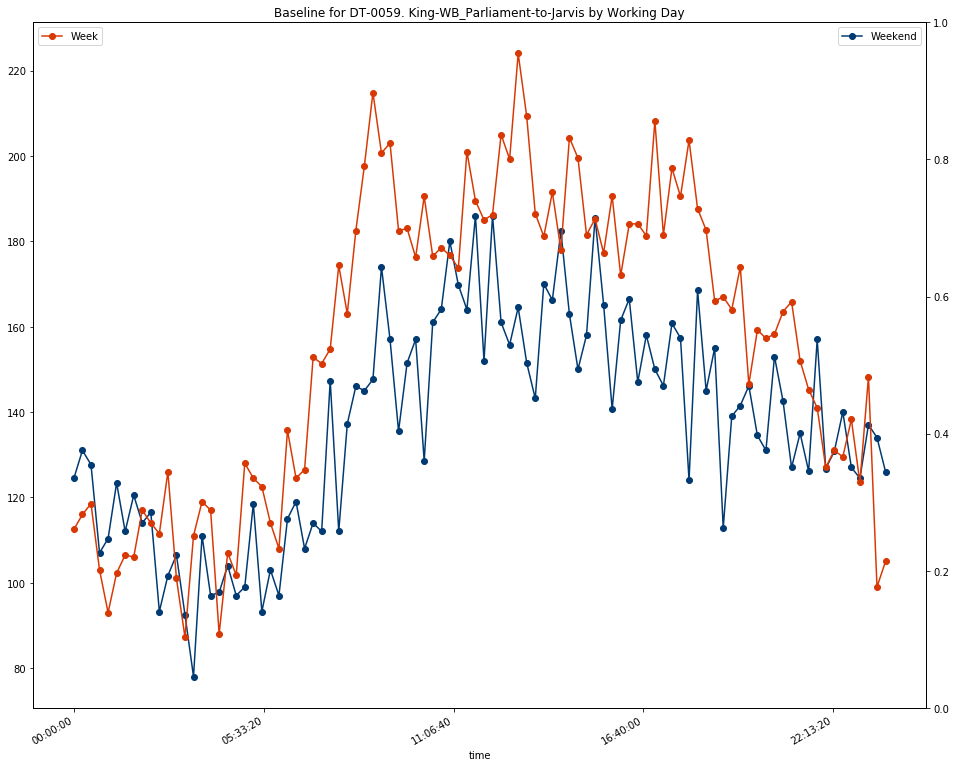

Thirty minute buckets


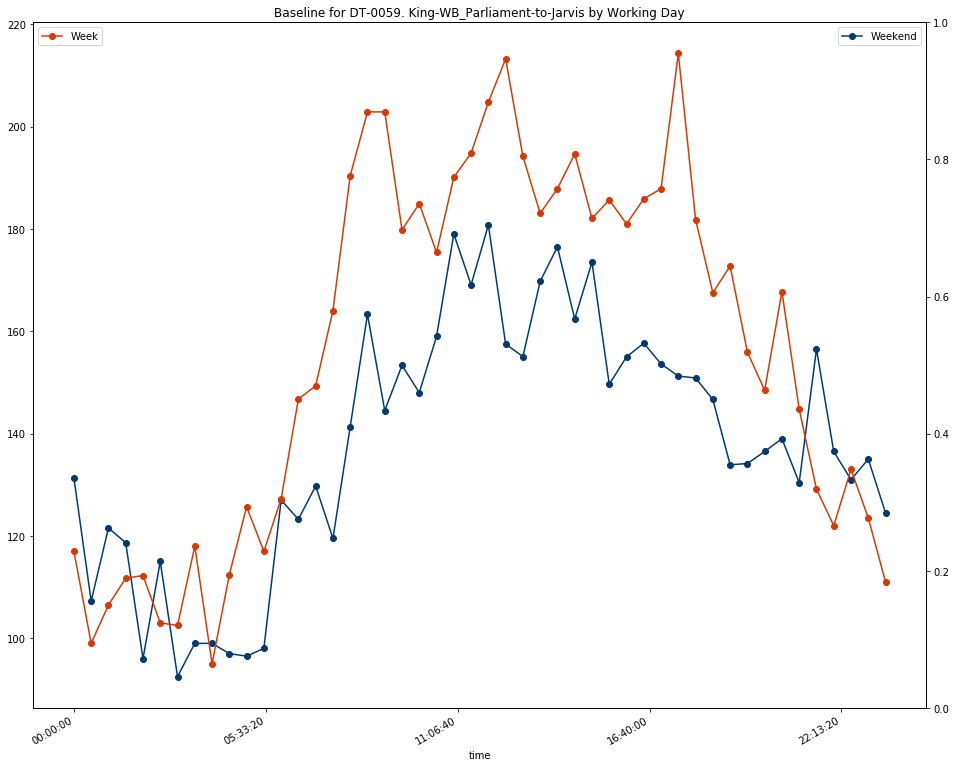

In [57]:
print('Fifteen minute buckets')
plot_base(baselines_15, traveltime_30['report_name'].unique()[58])
print('Thirty minute buckets')
plot_base(baselines_30, traveltime_30['report_name'].unique()[58])

The fifteen minute bucket baseline seems to vary rapidly, making it difficult to interpret. Changing to 30 minute aggregation makes for a much cleaner graph.

Now to build a set of functions to quickly plot graphs for a given segment.

In [58]:

travelsql_30 = '''
SELECT bt.travel_time, 
    bt.datetime_bin, 
    bt.analysis_id,
    EXTRACT(ISODOW FROM datetime_bin) as weekday,
    CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END as workingday,
    aa.report_name
FROM dt_30min_agg bt
    INNER JOIN bluetooth.all_analyses aa ON (bt.analysis_id = aa.analysis_id)
    LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)

WHERE hol.dt is NULL
'''
traveltime_30 = pandasql.read_sql(travelsql_30, con)

In [59]:
def WOY(x, W):
    return x.weekofyear == W

def week_dict(r_name):
    weeks = {W : traveltime_30[(traveltime_30['report_name'] == r_name) & 
                 traveltime_30['datetime_bin'].apply(WOY, args = (W,))]
            for W in traveltime_30.datetime_bin.apply(lambda x : x.weekofyear).unique()}
   # print(r_name)
   # print(weeks[weeks.keys()[1]])
    
    temp = {}
    for week, df in weeks.items():
        if df.travel_time.count() > 1: 
#if there is one point, the data is useless, and the graph has no x limit casuding MAXTICKS error
            temp[week] = weeks[week]
        else:
            if week in temp:
                del temp[week]
  #  print(weeks[weeks.keys()[1]])
    return temp

Creates a dictionary to store the bluetooth observations (30 minute) divided by week and removes empty weeks to keep the graph clean

In [60]:
def plot_weeks(seg_name):
    segment = week_dict(seg_name)
    fig, ax = plt.subplots(len(segment.keys()), 1, sharex = False, sharey = True, figsize = (16, 25))
    plt.suptitle('Travel times by week for ' + str(seg_name))
    for i, week in enumerate(segment):
        ax[i].plot_date(x = segment[week].datetime_bin,
                        y = segment[week].travel_time)

        min_loc = mdates.HourLocator(interval = 3)
        maj_loc = mdates.WeekdayLocator(byweekday = [0, 1, 2, 3, 4, 5, 6])

        ax[i].xaxis.set_major_locator(maj_loc)
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('\n%a %Y-%m-%d'))
        ax[i].xaxis.set_minor_locator(min_loc)
        ax[i].xaxis.set_minor_formatter(mdates.DateFormatter('%H'))

        ax[i].set_title(str(week))
        ax[i].set_xlabel('Time')
        ax[i].set_ylabel('Travel Time')
        ax[i].legend()
        ax[i].xaxis.grid(True, which="major")
        ax[i].yaxis.grid(True, which="major")

    fig.tight_layout()

    fig.subplots_adjust(top=0.95)
    
    plt.show()

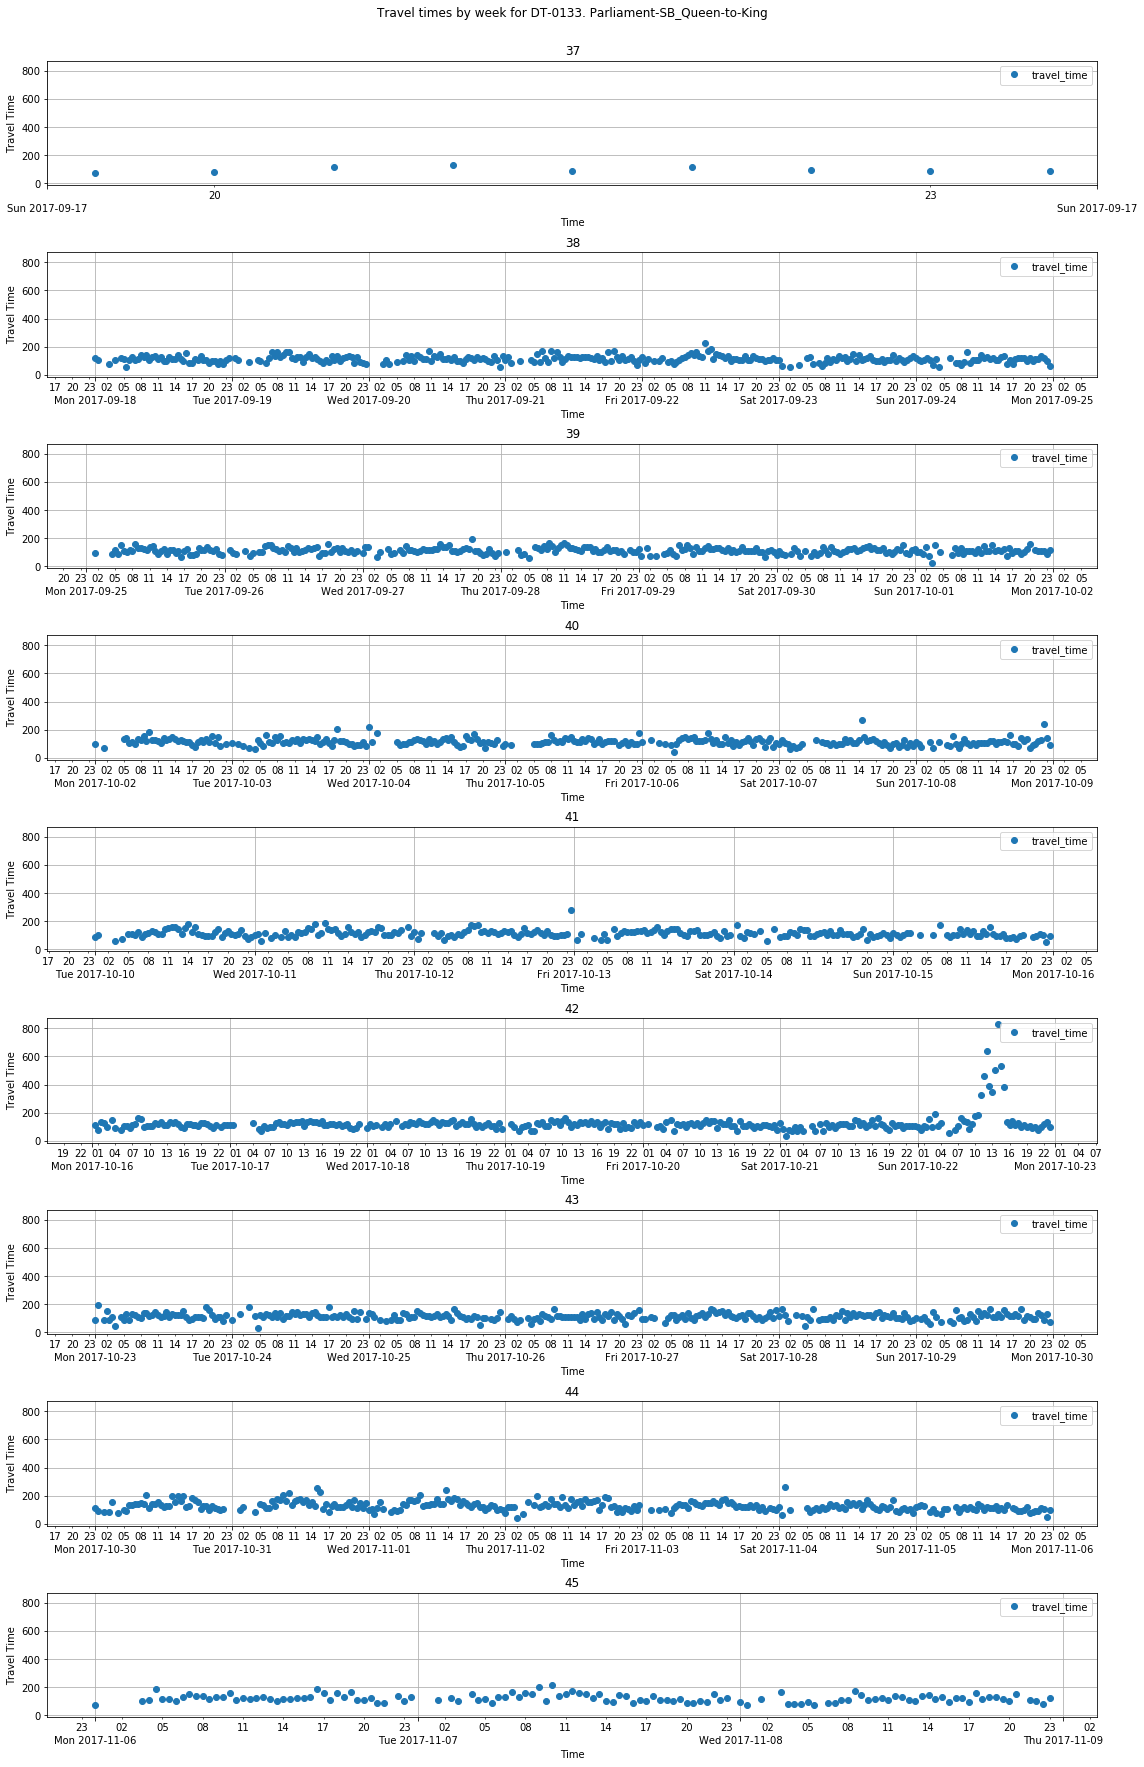

In [61]:
plot_weeks('DT-0133. Parliament-SB_Queen-to-King')

These plots revealed a few anomalies. Most were single points much higher than the rest of the data. There was also an instance of a group of a larger group of points making a slowdown that was much larger than any other recorded for the segment.

In [62]:
traveltime_30['report_name'].unique() #for reference above

array(['DT-0001.College-EB_Bathurst-to-University',
       'DT-0002. College-EB_University-to-Parliament',
       'DT-0003. College-WB_Parliament-to-University',
       'DT-0004. College-WB_University-to-Bathurst',
       'DT-0005. Dundas-EB_Roncesvalles-to-Dufferin',
       'DT-0006. Dundas-EB_Dufferin-to-Bathurst',
       'DT-0007. Dundas-EB_Bathurst-to-Spadina',
       'DT-0008. Dundas-EB_Spadina-to-University',
       'DT-0009. Dundas-EB_University-to-Yonge',
       'DT-0010. Dundas-EB_Yonge-to-Jarvis',
       'DT-0011. Dundas-EB_Jarvis-to-Parliament',
       'DT-0012. Dundas-WB_Parliament-to-Jarvis',
       'DT-0013. Dundas-WB_Jarvis-to-Yonge',
       'DT-0014. Dundas-WB_Yonge-to-University',
       'DT-0015. Dundas-WB_University-to-Spadina',
       'DT-0016. Dundas-WB_Spadina-to-Bathurst',
       'DT-0017. Dundas-WB_Bathurst-to-Dufferin',
       'DT-0018. Dundas-WB_Dufferin-to-Roncesvalles',
       'DT-0019. Queen-EB_Roncesvalles-to-Dufferin',
       'DT-0020. Queen-EB_Dufferin-t

In [63]:
cut_days = ['2017-10-22']
colors = ['#003A72', '#d83904']

In [64]:
cut_day_str = '(\'' + cut_days[0]
for day in cut_days[1:]:
    cut_day_str = cut_day_str + '\', \'' + day
cut_day_str = cut_day_str + '\')'

In [65]:
sql_mod = '''
WITH bt as(
SELECT * 
FROM dt_30min_agg blu
WHERE blu.datetime_bin::date NOT IN {}
    AND datetime_bin::date NOT BETWEEN '2017-10-15' AND '2017-10-29')

SELECT datetime_bin::time as time, 
    percentile_cont(0.5) WITHIN GROUP(ORDER BY bt.travel_time) as travel_time,
    CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END as workingday,
    aa.report_name

FROM  bt
    INNER JOIN bluetooth.all_analyses aa USING(analysis_id)
    LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    
WHERE hol.dt is NULL

GROUP BY aa.report_name, 
    datetime_bin::time, 
    CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END
'''.format(cut_day_str)

new_base = pandasql.read_sql(sql_mod, con)

The baseline query from above, modified to exclude anomalistic dates.

C:\Program Files\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


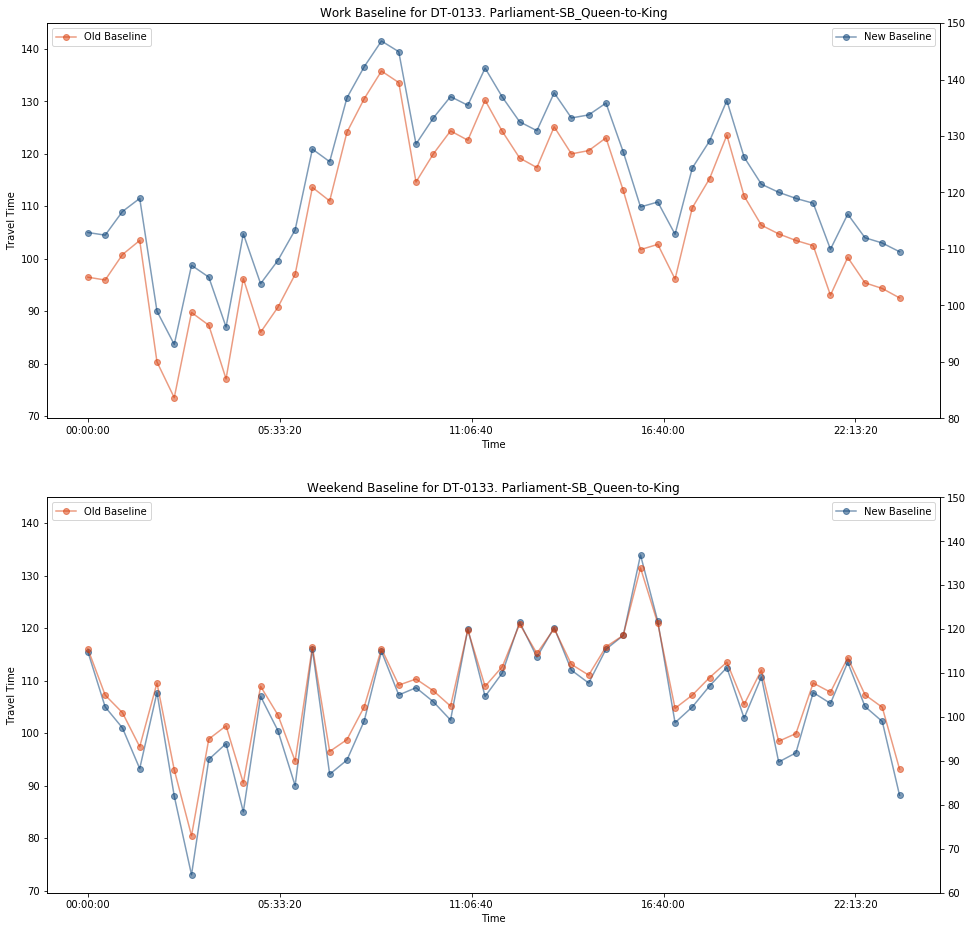

In [73]:
r_name = 'DT-0133. Parliament-SB_Queen-to-King'
fig, days = plt.subplots(2, 1, figsize = (16,16), sharey = True)
old = []

segments = {order : {'Work' : observations[(observations['report_name'] == r_name) & 
                                           (observations['workingday'] == 'Work')].sort_values(['time']),
                     'Weekend' : observations[(observations['report_name'] == r_name) & 
                                                (observations['workingday'] == 'Weekend')].sort_values(['time'])}
            for order, observations in zip(['New', 'Old'],[new_base, baselines_30])}


for i, WD in enumerate(['Work', 'Weekend']):
    old.append(days[i].twinx())
    days[i].plot_date(x = segments['New'][WD].time,
                      y = segments['New'][WD].travel_time,
                      xdate = True,
                      fmt = '-o',
                      c = colors[0],
                      alpha = 0.5,
                      label = 'New Baseline')
    plt.legend()
    old[i].plot_date(x = segments['Old'][WD].time,
                     y = segments['Old'][WD].travel_time,
                     xdate = True,
                     fmt = '-o',
                     c = colors[1],
                     alpha = 0.5,
                     label = 'Old Baseline')
    
    #old[i].get_xaxis().set_visible(False)
    #old[i].get_yaxis().set_visible(False)
    old[i].set_yticks(np.linspace(days[i].get_yticks()[0],days[i].get_yticks()[-1],len(days[i].get_yticks())))
    plt.title(str(WD) + ' Baseline for ' + r_name)
    days[i].xaxis.set_label_text('Time')
    days[i].yaxis.set_label_text('Travel Time')
    days[i].legend()
    old[i].legend(loc = 'upper left')
    #days[i].xaxis.set_major_locator(mdates.HourLocator(byhour = range(0, 23 ,1)))
    #days[i].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    #plt.gcf().autofmt_xdate()

plt.show(days[i])
plt.show(old[i])

With the anomalous days removed, the baseline is still fairly close to what it was originally. 